In [68]:
import pandas as pd
from tqdm import tqdm
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from collections import defaultdict
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import make_biclusters
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
sns.set(color_codes=True)

In [11]:
df1 = pd.DataFrame(pd.read_csv('./data/ijcai2016_taobao.csv',header=0))

In [12]:
len(df1['use_ID'].value_counts())

963923

In [22]:
df1[:100]

,use_ID,sel_ID,ite_ID,cat_ID,act_ID,time
0,1980536,9666,1450952,1,0,20150826
1,1980536,9666,1450952,1,0,20150826
2,647747,9666,1450952,1,0,20150915
3,1980536,9666,1450952,1,0,20150823
4,183647,9525,578730,1,0,20150711
5,723956,589,28301,1,0,20150825
6,1781938,589,28301,1,0,20150724
7,1652831,589,1533782,1,0,20150702
8,416403,2316,1129278,1,0,20151006
9,43130,4058,1745953,1,0,20151019


In [8]:
user_seller_maps = {}
for i in tqdm(range(len(df1))):
    if df1.iloc[i].use_ID not in user_seller_maps:
        user_seller_maps[df1.iloc[i].use_ID] = {}
        user_seller_maps[df1.iloc[i].use_ID][df1.iloc[i].sel_ID] = 1
    else:
        if df1.iloc[i].sel_ID not in user_seller_maps[df1.iloc[i].use_ID]:
            user_seller_maps[df1.iloc[i].use_ID][df1.iloc[i].sel_ID] = 1
        else:
            user_seller_maps[df1.iloc[i].use_ID][df1.iloc[i].sel_ID] += 1

100%|██████████| 44528127/44528127 [17:51:38<00:00, 692.52it/s]  


In [9]:
user_new_old_id_maps = {}
user_old_new_id_maps = {}
count = 0
for u in tqdm(user_seller_maps):
    user_new_old_id_maps[count] = u
    user_old_new_id_maps[u] = count
    count += 1

100%|██████████| 963923/963923 [00:01<00:00, 674788.77it/s]


In [10]:
user_seller_matrix = np.zeros((len(user_seller_maps), 10000))
for i in tqdm(user_seller_maps):
    for j in user_seller_maps[i]:
        user_seller_matrix[user_old_new_id_maps[i]][j-1] = user_seller_maps[i][j]

100%|██████████| 963923/963923 [00:55<00:00, 17523.83it/s]


In [11]:
np.save("user_seller_matrix.npy", user_seller_matrix)
# user_seller_matrix = np.load("user_seller_matrix.npy")

In [14]:
seller_maps = dict(df1['sel_ID'].value_counts())
print(seller_maps)

{2086: 437344, 4913: 358456, 7522: 354084, 528: 259968, 5612: 253881, 8417: 197433, 2920: 184671, 5352: 183899, 6045: 152448, 529: 151392, 2727: 144576, 6380: 141205, 8490: 140372, 7858: 137612, 1828: 137300, 8762: 137015, 6433: 132895, 5414: 129024, 641: 128327, 5442: 124927, 5085: 123119, 7065: 119000, 7823: 112295, 6792: 110414, 8953: 99787, 4230: 99625, 6857: 99144, 5752: 98604, 6360: 98050, 3958: 97238, 9987: 96613, 4562: 96237, 4870: 94646, 7887: 93054, 6883: 91659, 9410: 91311, 9093: 87949, 517: 85453, 4659: 82762, 4855: 80954, 2373: 80940, 8084: 79333, 9883: 79138, 7401: 77628, 582: 74980, 2154: 74478, 9955: 73028, 7705: 70349, 7866: 69867, 5468: 69767, 6793: 66322, 5432: 63428, 6658: 63151, 2468: 62679, 4557: 62530, 5053: 62416, 6087: 60532, 8140: 60044, 2442: 58631, 5687: 56813, 5245: 55946, 2227: 55240, 5776: 54351, 6545: 54230, 9082: 53480, 2674: 52278, 1225: 51262, 3157: 50454, 1526: 50311, 8761: 49507, 3297: 49426, 3845: 49231, 8522: 48560, 5619: 48389, 1662: 47045, 9947:

In [15]:
out_df = pd.DataFrame(list(seller_maps.items()), columns=['seller_id', 'records_number'])
print(out_df[:5])

   seller_id  records_number
0       2086          437344
1       4913          358456
2       7522          354084
3        528          259968
4       5612          253881


In [16]:
seller_infos = {}
for k in seller_maps:
    seller_infos[k] = df1[df1.sel_ID==k]
print(seller_infos[4058][:5])

    use_ID  sel_ID   ite_ID  cat_ID  act_ID      time
9    43130    4058  1745953       1       0  20151019
10  502518    4058  1745953       1       0  20150902
11  109400    4058  1745953       1       0  20151010
12  488933    4058  1745953       1       0  20151028
13  488933    4058  1745953       1       0  20151028


In [17]:
# action related features
# buy_click_ratio = []
buy_count = []
click_count = []
successful_trade_ratio = []
for k in tqdm(range(len(out_df))):
    sel_id = out_df.iloc[k].seller_id
    click_number = len(seller_infos[sel_id][seller_infos[sel_id].act_ID==0])
    buy_number = len(seller_infos[sel_id][seller_infos[sel_id].act_ID==1])
#     buy_click_ratio.append(float(buy_number)/(click_number+0.0001))
    buy_count.append(buy_number)
    click_count.append(click_number)
    successful_trade_ratio.append(float(buy_number)/(click_number+buy_number))
#     if buy_click_ratio[-1] > 1.0:
#         print(click_number, buy_number)
out_df['buy_count'] = buy_count
out_df['click_count'] = click_count
out_df['successful_trade_ratio'] = successful_trade_ratio 

100%|██████████| 10000/10000 [00:14<00:00, 676.59it/s]


In [23]:
out_df[:100]

,seller_id,records_number,buy_count,click_count,successful_trade_ratio,item_number,category_number,average_purchase_interval,last_purchase_date,openning_date,maximum_click_per_day,maximum_purchase_per_day
0,2086,437344,40943,396401,0.093617,317,20,0.000348,153.0,1.0,39988,1035
1,4913,358456,38593,319863,0.107665,4459,19,0.000424,153.0,1.0,4478,634
2,7522,354084,353841,243,0.999314,1,1,0.000429,153.0,1.0,12,5479
3,528,259968,115151,144817,0.442943,1824,3,0.000585,153.0,1.0,2811,1917
4,5612,253881,3467,250414,0.013656,97,3,0.000599,153.0,1.0,22534,441
5,8417,197433,4806,192627,0.024342,13636,9,0.000770,153.0,1.0,3361,278
6,2920,184671,5797,178874,0.031391,5435,3,0.000823,153.0,1.0,6374,383
7,5352,183899,5681,178218,0.030892,2133,7,0.000827,153.0,1.0,6851,71
8,6045,152448,11566,140882,0.075868,5186,14,0.000997,153.0,1.0,6407,1309
9,529,151392,11379,140013,0.075162,5546,6,0.001004,153.0,1.0,5196,881


In [19]:
item_number = []
# category_onehot = [[0 for i in range(72)] for j in range(len(out_df))]
category_number = []
for k in tqdm(range(len(out_df))):
    sel_id = out_df.iloc[k].seller_id
    item_number.append(len(seller_infos[sel_id]['ite_ID'].value_counts()))
    category_number.append(len(seller_infos[sel_id]['cat_ID'].value_counts()))
#     for item in range(len(seller_infos[sel_id])):
#         category_onehot[k][seller_infos[sel_id].iloc[item].cat_ID-1] = 1
out_df['item_number'] = item_number
out_df['category_number'] = category_number
# category_onehot = np.array(category_onehot)
# print(category_onehot.shape)
# for i in range(72):
#     out_df['category_onehot_'+str(i+1)] = category_onehot[:, i]

100%|██████████| 10000/10000 [00:10<00:00, 944.38it/s]


In [20]:
# time features
import time
import datetime

START = '20150630'
#计算两个日期相差天数，自定义函数名，和两个日期的变量名。
def Caltime(date1,date2):
    #%Y-%m-%d为日期格式，其中的-可以用其他代替或者不写，但是要统一，同理后面的时分秒也一样；可以只计算日期，不计算时间。
    #date1=time.strptime(date1,"%Y-%m-%d %H:%M:%S") 
    #date2=time.strptime(date2,"%Y-%m-%d %H:%M:%S")
    date1=time.strptime(date1,"%Y%m%d")
    date2=time.strptime(date2,"%Y%m%d")
    #根据上面需要计算日期还是日期时间，来确定需要几个数组段。下标0表示年，小标1表示月，依次类推...
    #date1=datetime.datetime(date1[0],date1[1],date1[2],date1[3],date1[4],date1[5])
    #date2=datetime.datetime(date2[0],date2[1],date2[2],date2[3],date2[4],date2[5])
    date1=datetime.datetime(date1[0],date1[1],date1[2])
    date2=datetime.datetime(date2[0],date2[1],date2[2])
    #返回两个变量相差的值，就是相差天数
    return date2-date1

print(str(Caltime('00010101', '20150831')).split()[0])

openning_date = []
openning_interval = []
last_purchase_date = []
average_purchase_interval = []

for k in tqdm(range(len(out_df))):
    sel_id = out_df.iloc[k].seller_id
    sorted_seller_info = seller_infos[sel_id].sort_values(by = ['time'])
    openning_date.append(float(str(Caltime(START, str(sorted_seller_info.iloc[0].time))).split()[0]))
    last_purchase_date.append(float(str(Caltime(START, str(sorted_seller_info.iloc[-1].time))).split()[0]))
    average_purchase_interval.append(float(str(Caltime(str(sorted_seller_info.iloc[0].time), str(sorted_seller_info.iloc[-1].time))).split()[0])
                                     /out_df.iloc[k].records_number)
#     if sorted_seller_info.iloc[0].time != 20150701 or sorted_seller_info.iloc[-1].time != 20151130:
#         count += 1
#         print(sel_id, sorted_seller_info.iloc[0].time, sorted_seller_info.iloc[-1].time)

# should be attention_interval
out_df['average_purchase_interval'] = average_purchase_interval
out_df['last_purchase_date'] = last_purchase_date
out_df['openning_date'] = openning_date

  0%|          | 2/10000 [00:00<10:13, 16.30it/s]

735840


100%|██████████| 10000/10000 [00:16<00:00, 604.96it/s]


In [21]:
# maximum purchase/clicking number per day
maximum_purchase_per_day = []
maximum_click_per_day = []
for k in tqdm(range(len(out_df))):
    sel_id = out_df.iloc[k].seller_id
    seller_click_subset = seller_infos[sel_id][seller_infos[sel_id].act_ID==0]
    seller_buy_subset = seller_infos[sel_id][seller_infos[sel_id].act_ID==1]
    buy_ = seller_buy_subset.groupby(['sel_ID', 'time']).size()
    click_ = seller_click_subset.groupby(['sel_ID', 'time']).size()
    if len(buy_) > 0:
        maximum_purchase_per_day.append(max(buy_))
    else:
        maximum_purchase_per_day.append(0)
    if len(click_) > 0:
        maximum_click_per_day.append(max(click_))
    else:
        maximum_click_per_day.append(0)
out_df['maximum_click_per_day'] = maximum_click_per_day
out_df['maximum_purchase_per_day'] = maximum_purchase_per_day
# print(len(maximum_purchase_per_day), len(maximum_click_per_day)) 

100%|██████████| 10000/10000 [00:31<00:00, 321.91it/s]


In [ ]:
user_seller_matrix = np.load("user_seller_matrix.npy")
print(user_seller_matrix.shape)

In [ ]:
# SVD, Matrix Factorization
from sklearn.decomposition import NMF
# user_seller_matrix

# S = np.random.rand(10000, 10000)
# for i in tqdm(range(2, 11)):
nmf_model = NMF(n_components=10) 
item_dis = nmf_model.fit_transform(user_seller_matrix)
user_dis = nmf_model.components_
print(item_dis.shape, user_dis.shape)
print(nmf_model.reconstruction_err_)


In [ ]:
user_df = pd.DataFrame(user_dis.T)

In [ ]:
user_df[:10]

In [ ]:
item_df = pd.DataFrame(item_dis)

In [ ]:
item_df[:10]

In [ ]:
np.save("user_dis.npy", user_dis)
np.save("item_dis.npy", item_dis)

In [24]:
# Normalization
X = np.array(out_df)
min_max_scaler = preprocessing.MinMaxScaler()  
X_minMax = min_max_scaler.fit_transform(X)
print(X[:1, :])
print(X_minMax[:1, :])

[[2.08600000e+03 4.37344000e+05 4.09430000e+04 3.96401000e+05
  9.36173813e-02 3.17000000e+02 2.00000000e+01 3.47552499e-04
  1.53000000e+02 1.00000000e+00 3.99880000e+04 1.03500000e+03]]
[[0.20852085 1.         0.11571016 1.         0.09361738 0.00806369
  0.44186047 0.         1.         0.         0.91424129 0.18126095]]


In [40]:
min_max_scaler = preprocessing.MinMaxScaler()  
X_minMax = min_max_scaler.fit_transform(X)
print(X_minMax.shape)

(10000, 11)


In [27]:
Seller_SVD = np.load("seller_dis.npy")
print(Seller_SVD.shape)

(100, 10000)


In [31]:
svd_X = np.concatenate((X, Seller_SVD.T), axis=1)
print(svd_X.shape)

(10000, 111)


In [32]:
# Normalization
min_max_scaler = preprocessing.MinMaxScaler()  
svd_X_minMax = min_max_scaler.fit_transform(svd_X)
print(svd_X[:1, :])
print(svd_X_minMax[:1, :])

[[2.08600000e+03 4.37344000e+05 4.09430000e+04 3.96401000e+05
  9.36173813e-02 3.17000000e+02 2.00000000e+01 3.47552499e-04
  1.00000000e+00 3.99880000e+04 1.03500000e+03 7.21592176e-05
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.80552587e-04 1.19627082e-05 2.97801052e-05 8.14628838e-03
  2.19157918e-03 1.91355063e-06 1.15443182e-05 1.77281054e-05
  7.56322583e-03 1.30500687e-05 4.81479033e-03 1.95306035e-05
  0.00000000e+00 1.04466782e-05 6.42450195e-04 4.02762909e-05
  0.00000000e+00 5.90138487e-06 8.47213479e-03 2.29873399e-03
  4.14123193e-03 0.00000000e+00 2.37104534e-04 0.00000000e+00
  5.31263337e-03 7.58043356e-04 8.58291171e-04 4.72027444e-03
  3.93143866e-05 2.20935469e-03 0.00000000e+00 0.00000000e+00
  5.19359737e-03 0.00000000e+00 0.00000000e+00 1.45006845e-02
  0.00000000e+00 0.00000000e+00 2.26501255e-06 2.65611869e-03
  1.49149294e-04 1.12846030e-03 3.32814374e-04 1.03268701e-02
  5.5470

In [33]:
def select_k_and_display(k_list, X):
    Calinski_Harabasz_k = 0
    Calinski_Harabasz_score = -1
    Calinski_Harabasz_cls = None
    Silhouette_k = 0
    Silhouette_score = -1
    Silhouette_cls = None
    for i in k_list:
        clustering = SpectralClustering(n_clusters=i,
                                        n_init=10, 
                                        gamma=1.0,
                                        affinity='rbf',
                                        assign_labels ='kmeans',
                                        n_jobs=5)
        cls = clustering.fit(X)
        y_pred = clustering.fit_predict(X)
        ch_score = metrics.calinski_harabaz_score(X, y_pred)
        s_score = metrics.silhouette_score(X, cls.labels_, metric='euclidean')
        print("Calinski-Harabasz Score with n_clusters=", i,"score:", ch_score)
            
        print("Silhouette Score with n_clusters=", i,"score:", s_score)
        if ch_score > Calinski_Harabasz_score:
            Calinski_Harabasz_score = ch_score
            Calinski_Harabasz_k = i
            Calinski_Harabasz_cls = cls
        if abs(s_score - 1) < abs(Silhouette_score - 1):
            Silhouette_score = s_score
            Silhouette_k = i
            Silhouette_cls = cls
    print("The best Silhouette Score is "+str(Silhouette_score)+" and the best k is "+str(Silhouette_k))
    print("The best Calinski-Harabasz Score is "+str(Calinski_Harabasz_score)+" and the best k is "+str(Calinski_Harabasz_k))
    if Silhouette_k == Calinski_Harabasz_k:
        index = []
        values = []
        cluster_maps = defaultdict(int)
        for i in range(len(X)):
            cluster_maps[Calinski_Harabasz_cls.labels_[i]] += 1
        for i in cluster_maps:
            index.append(i)
            values.append(cluster_maps[i])
        print(values)
        axes = plt.bar(index, values)
        plt.show()
        
        fit_X = X[np.argsort(Calinski_Harabasz_cls.labels_)]
        plt.matshow(X, cmap=plt.cm.Blues)
        plt.matshow(fit_X, cmap=plt.cm.Blues)
        plt.title("Clustering Result based on both Silhouette and Calinski_Harabasz Score")
        plt.show()
        
        plt.imshow(X)  
        plt.colorbar()
        plt.title("Original data visualization")
        plt.show() 
        
        plt.imshow(fit_X)  
        plt.colorbar()
        plt.title("Clustering Result based on both Silhouette and Calinski_Harabasz Score")
        plt.show()

        
    else:
        index = []
        values = []
        cluster_maps = defaultdict(int)
        for i in range(len(X)):
            cluster_maps[Calinski_Harabasz_cls.labels_[i]] += 1
        for i in cluster_maps:
            index.append(i)
            values.append(cluster_maps[i])
        print(Calinski_Harabasz_cls.get_params())
        print(values)
        axes = plt.bar(index, values)
        plt.show()
        
        fit_X = X[np.argsort(Calinski_Harabasz_cls.labels_)]
        plt.matshow(fit_X, cmap=plt.cm.Blues)
        plt.title("Clustering Result based on Calinski_Harabasz Score")
        plt.show()
        
        plt.imshow(X)  
        plt.colorbar()
        plt.title("Original data visualization")
        plt.show() 
        
        plt.imshow(fit_X)  
        plt.colorbar()
        plt.title("Clustering Result based on Calinski_Harabasz Score")
        plt.show()
        
        
        index = []
        values = []
        cluster_maps = defaultdict(int)
        for i in range(len(X)):
            cluster_maps[Silhouette_cls.labels_[i]] += 1
        for i in cluster_maps:
            index.append(i)
            values.append(cluster_maps[i])
        print(values)
        print(Silhouette_cls.get_params())
        axes = plt.bar(index, values)
        plt.show()
        
        fit_X = X[np.argsort(Silhouette_cls.labels_)]
        plt.matshow(fit_X, cmap=plt.cm.Blues)
        plt.title("Clustering Result based on Silhouette Score")
        plt.show()
        
        plt.imshow(fit_X)  
        plt.colorbar()
        plt.title("Clustering Result based on Silhouette Score")
        plt.show()
        
        


def draw_result_on_2d(X, k, labels):
    X_embedded = TSNE(n_components=2).fit_transform(X)

    pos = pd.DataFrame(X_embedded, columns=['X','Y'])
    pos['cluster'] = labels
    colors = ['red', 'blue', 'green', 'yellow', 'black', 'white', 'magenta', 'cyan']


    ax = pos[pos['cluster']==0].plot(kind='scatter', x='X', y='Y', color=colors[i%8], label='0')
    for i in range(1, k):
        pos[pos['cluster']==i].plot(kind='scatter', x='X', y='Y', color=colors[i%8], label=str(i), ax=ax)
    plt.show()
    


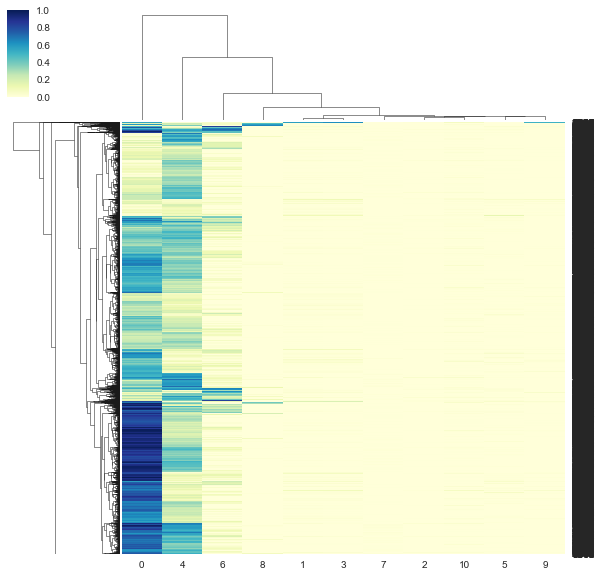

In [41]:
# draw clustering map for raw data (clustering data got the same result)
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import make_biclusters
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
# iris = sns.load_dataset("iris")
# data, rows, columns = make_biclusters(shape=(300, 300), n_clusters=5, noise=5, shuffle=False, random_state=0)
# species = iris.pop("species")
#设置图片大小
g= sns.clustermap(X_minMax, fmt="d",cmap='YlGnBu')
ax = g.ax_heatmap
label_y = ax.get_yticklabels()
plt.setp(label_y, rotation=360, horizontalalignment='left')
#设置图片名称，分辨率，并保存
# plt.savefig('cluster.tif',dpi = 300)
plt.show()

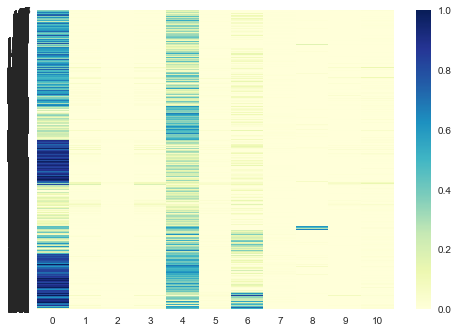

In [44]:
# draw heat map for clustering result
clustering = SpectralClustering(n_clusters=10,
                                # kmeans epochs
                                n_init=10, 
                                gamma=1.0,
                                affinity='rbf',
#                                 n_neighbors=10,
                                assign_labels ='kmeans',
#                                 degree=3,
#                                 coef0=1,
                                n_jobs=5).fit(X_minMax)
fit_X_minMax = X_minMax[np.argsort(clustering.labels_)]
sns.heatmap(fit_X_minMax, fmt="d", cmap='YlGnBu')
plt.show()

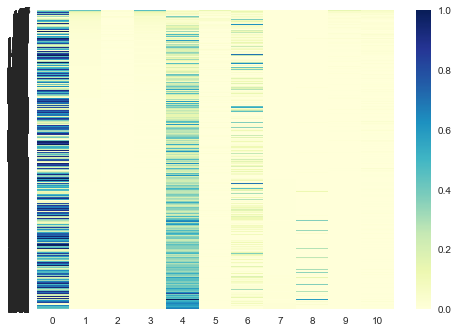

In [45]:
# draw for original data
sns.heatmap(X_minMax, fmt="d", cmap='YlGnBu')
plt.show()

In [48]:
print(svd_X_minMax.shape, X_minMax.shape)
np.save("seller_explcit_features.npy", X_minMax)
np.save("seller_explcit_svd_features.npy", svd_X_minMax)

(10000, 111) (10000, 11)


[84, 3192, 120, 453, 1406, 1363, 806, 1159, 1274, 143]


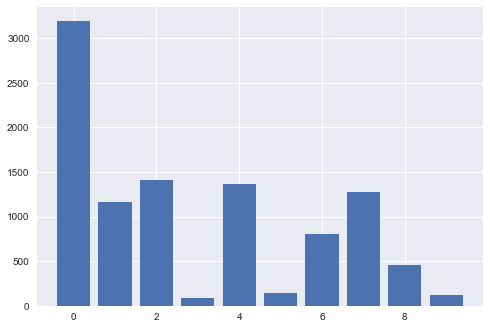

In [46]:
index = []
values = []
cluster_maps = defaultdict(int)
for i in range(len(X_minMax)):
    cluster_maps[clustering.labels_[i]] += 1
for i in cluster_maps:
    index.append(i)
    values.append(cluster_maps[i])
print(values)
axes = plt.bar(index, values)
plt.show()

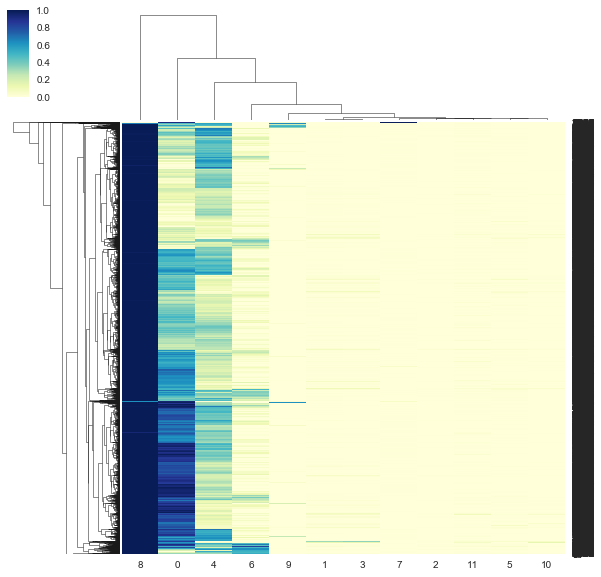

In [26]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import make_biclusters
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
# iris = sns.load_dataset("iris")
# data, rows, columns = make_biclusters(shape=(300, 300), n_clusters=5, noise=5, shuffle=False, random_state=0)
# species = iris.pop("species")
#设置图片大小
g= sns.clustermap(X_minMax, fmt="d",cmap='YlGnBu')
ax = g.ax_heatmap
label_y = ax.get_yticklabels()
plt.setp(label_y, rotation=360, horizontalalignment='left')
#设置图片名称，分辨率，并保存
# plt.savefig('cluster.tif',dpi = 300)
plt.show()

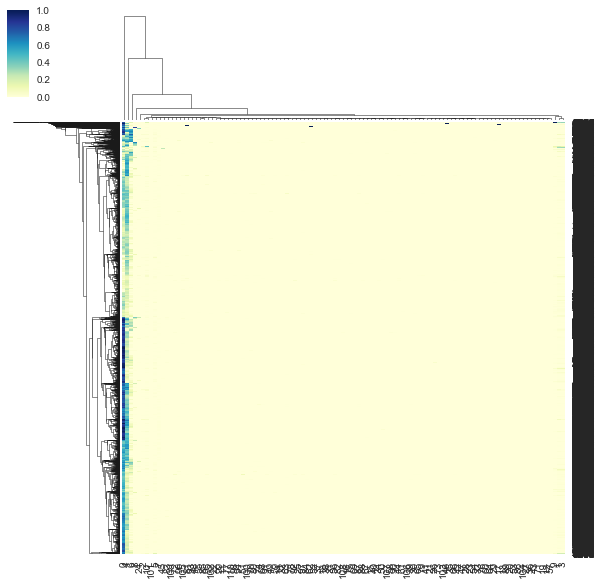

In [37]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import make_biclusters
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
# iris = sns.load_dataset("iris")
# data, rows, columns = make_biclusters(shape=(300, 300), n_clusters=5, noise=5, shuffle=False, random_state=0)
# species = iris.pop("species")
#设置图片大小
g= sns.clustermap(fit_X, fmt="d",cmap='YlGnBu')
ax = g.ax_heatmap
label_y = ax.get_yticklabels()
plt.setp(label_y, rotation=360, horizontalalignment='left')
#设置图片名称，分辨率，并保存
# plt.savefig('cluster.tif',dpi = 300)
plt.show()

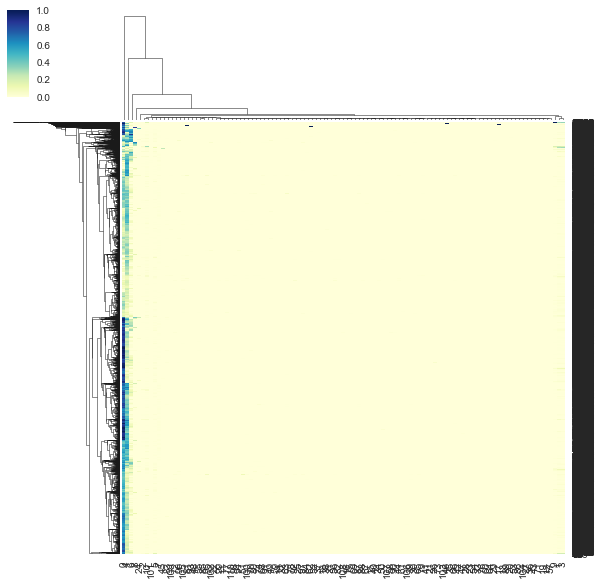

In [43]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import make_biclusters
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
# iris = sns.load_dataset("iris")
# data, rows, columns = make_biclusters(shape=(300, 300), n_clusters=5, noise=5, shuffle=False, random_state=0)
# species = iris.pop("species")
#设置图片大小
g= sns.clustermap(svd_X_minMax, fmt="d",cmap='YlGnBu')
ax = g.ax_heatmap
label_y = ax.get_yticklabels()
plt.setp(label_y, rotation=360, horizontalalignment='left')
#设置图片名称，分辨率，并保存
# plt.savefig('cluster.tif',dpi = 300)
plt.show()

In [96]:
def select_k(X):
    for gamma in [10, 1, 0.1, 0.01]:
        for k in [2,4,8,16,32,64]:
            y_pred = SpectralClustering(n_clusters=k,
                                        n_init=10, 
                                        gamma=gamma,
                                        affinity='rbf',
                                        assign_labels ='kmeans').fit_predict(X)
            print("Calinski-Harabasz Score with gamma=", 
            gamma, "n_clusters=", 
            k,"score:", 
            metrics.calinski_harabaz_score(X, y_pred))

#     distance = []
#     k = []
#     #簇的数量
#     for n_clusters in tqdm(range(1, 50, 2)):
#         clustering = SpectralClustering(n_clusters=n_clusters,
#                                 # kmeans epochs
#                                 n_init=10, 
#                                 gamma=1.0,
#                                 affinity='rbf',
# #                                 n_neighbors=10,
#                                 assign_labels ='kmeans',
# #                                 degree=3,
# #                                 coef0=1,
#                                 n_jobs=5).fit(X_minMax)

#         #曼哈顿距离
#         def manhattan_distance(x,y):
#             return np.sum(abs(x-y))

#         distance_sum = 0
#         for i in range(n_clusters):
#             group = clustering.labels_ == i
#             members = X[group,:]
#             for v in members:
#                 distance_sum += manhattan_distance(np.array(v), clustering.cluster_centers_[i])
#         distance.append(distance_sum)
#         k.append(n_clusters)
#     plt.scatter(k, distance)
#     plt.plot(k, distance)
#     plt.xlabel("k")
#     plt.ylabel("distance")
#     plt.show()
select_k(X_minMax)

/Users/billywang/anaconda3/lib/python3.6/site-packages/sklearn/utils/graph.py:115: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, np.int)


Calinski-Harabasz Score with gamma= 10 n_clusters= 2 score: 169.02533939277652
Calinski-Harabasz Score with gamma= 10 n_clusters= 4 score: 4288.472496742024
Calinski-Harabasz Score with gamma= 10 n_clusters= 8 score: 3862.649393420191
Calinski-Harabasz Score with gamma= 10 n_clusters= 16 score: 2580.336941627541
Calinski-Harabasz Score with gamma= 10 n_clusters= 32 score: 1770.9592514741353
Calinski-Harabasz Score with gamma= 10 n_clusters= 64 score: 1185.023788402006
Calinski-Harabasz Score with gamma= 1 n_clusters= 2 score: 9599.714307126162
Calinski-Harabasz Score with gamma= 1 n_clusters= 4 score: 3959.4122029897335
Calinski-Harabasz Score with gamma= 1 n_clusters= 8 score: 3984.2951904406154
Calinski-Harabasz Score with gamma= 1 n_clusters= 16 score: 2416.624203880871
Calinski-Harabasz Score with gamma= 1 n_clusters= 32 score: 1624.7497411571326
Calinski-Harabasz Score with gamma= 1 n_clusters= 64 score: 945.3410829370237
Calinski-Harabasz Score with gamma= 0.1 n_clusters= 2 score

In [97]:
def select_k_silhouette(X):
    for gamma in [10, 1, 0.1, 0.01]:
        for k in [2,4,8,16,32,64]:
            cls = SpectralClustering(n_clusters=k,
                                        n_init=10, 
                                        gamma=gamma,
                                        affinity='rbf',
                                        assign_labels ='kmeans').fit(X)
            print("Silhouette Score with gamma=", 
            gamma, "n_clusters=", 
            k,"score:", 
            metrics.silhouette_score(X, cls.labels_, metric='euclidean'))
select_k_silhouette(X_minMax)

/Users/billywang/anaconda3/lib/python3.6/site-packages/sklearn/utils/graph.py:115: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, np.int)


Silhouette Score with gamma= 10 n_clusters= 2 score: 0.14363682963027383
Silhouette Score with gamma= 10 n_clusters= 4 score: 0.2522665391218191
Silhouette Score with gamma= 10 n_clusters= 8 score: 0.24184253863026137
Silhouette Score with gamma= 10 n_clusters= 16 score: 0.19587225454368726
Silhouette Score with gamma= 10 n_clusters= 32 score: 0.211753423265281
Silhouette Score with gamma= 10 n_clusters= 64 score: 0.2045606312443067
Silhouette Score with gamma= 1 n_clusters= 2 score: 0.4245058662423324
Silhouette Score with gamma= 1 n_clusters= 4 score: 0.28542354183331065
Silhouette Score with gamma= 1 n_clusters= 8 score: 0.2635096934761079
Silhouette Score with gamma= 1 n_clusters= 16 score: 0.18831546964624166
Silhouette Score with gamma= 1 n_clusters= 32 score: 0.17598470020520932
Silhouette Score with gamma= 1 n_clusters= 64 score: 0.1010352301446696
Silhouette Score with gamma= 0.1 n_clusters= 2 score: 0.42450549224981204
Silhouette Score with gamma= 0.1 n_clusters= 4 score: 0.2

In [49]:
def select_k_and_display(k_list, data):
    Calinski_Harabasz_k = 0
    Calinski_Harabasz_score = -1
    Calinski_Harabasz_cls = None
    ch_score_series = []
    
    Silhouette_k = 0
    Silhouette_score = -1
    Silhouette_cls = None
    sc_score_series = []
    for i in k_list:
        clustering = SpectralClustering(n_clusters=i,
                                        n_init=10, 
                                        gamma=1.0,
                                        affinity='rbf',
                                        assign_labels ='kmeans',
                                        n_jobs=5)
        cls = clustering.fit(data)
        y_pred = clustering.fit_predict(data)
        ch_score = metrics.calinski_harabaz_score(data, y_pred)
        s_score = metrics.silhouette_score(data, cls.labels_, metric='euclidean')
        
        ch_score_series.append(ch_score)
        sc_score_series.append(s_score)
        
        print("Calinski-Harabasz Score with n_clusters=", i,"score:", ch_score)
        print("Silhouette Score with n_clusters=", i,"score:", s_score)
        
        if ch_score > Calinski_Harabasz_score:
            Calinski_Harabasz_score = ch_score
            Calinski_Harabasz_k = i
            Calinski_Harabasz_cls = cls
            
        if abs(s_score - 1) < abs(Silhouette_score - 1):
            Silhouette_score = s_score
            Silhouette_k = i
            Silhouette_cls = cls
            
    print("The best Silhouette Score is "+str(Silhouette_score)+" and the best k is "+str(Silhouette_k))
    print("The best Calinski-Harabasz Score is "+str(Calinski_Harabasz_score)+" and the best k is "+str(Calinski_Harabasz_k))
    
    if Silhouette_k == Calinski_Harabasz_k:
        fit_data = data[np.argsort(Calinski_Harabasz_cls.labels_)]
#         heat_map_for_original(fit_data)
        show_clusters(data, Calinski_Harabasz_cls)
        
    else:
        ch_fit_data = data[np.argsort(Calinski_Harabasz_cls.labels_)]
#         heat_map_for_original(ch_fit_data)
        show_clusters(ch_fit_data, Calinski_Harabasz_cls)
        
        sc_fit_data = data[np.argsort(Silhouette_cls.labels_)]
#         heat_map_for_original(sc_fit_data)
        show_clusters(sc_fit_data, Silhouette_cls)
        
    plt.plot(k_list, ch_score_series)
    plt.title('Calinski_Harabasz_score trend with k increasing')
    plt.xlabel('k component number')
    plt.ylabel('Calinski_Harabasz_score')
#     plt.legend()
    plt.show()
    
    plt.plot(k_list, sc_score_series)
    plt.title('Silhouette_score trend with k increasing')
    plt.xlabel('k component number')
    plt.ylabel('Silhouette_score')
#     plt.legend()
    plt.show()

In [50]:
def heat_map_for_original(X):
    sns.heatmap(X, fmt="d", cmap='YlGnBu')
    plt.show()
def normalization(X):
    min_max_scaler = preprocessing.MinMaxScaler()  
    X_minMax = min_max_scaler.fit_transform(X)
    print(X[:1, :])
    print(X_minMax[:1, :])
    return X_minMax
def show_clusters(data, clustering):
    index = []
    values = []
    cluster_maps = defaultdict(int)
    for i in range(len(data)):
        cluster_maps[clustering.labels_[i]] += 1
    for i in cluster_maps:
        index.append(i)
        values.append(cluster_maps[i])
    print(values)
    axes = plt.bar(index, values)
    plt.show()

Calinski-Harabasz Score with n_clusters= 5 score: 4408.82230824398
Silhouette Score with n_clusters= 5 score: 0.2728913074777981
Calinski-Harabasz Score with n_clusters= 10 score: 3172.3142910891606
Silhouette Score with n_clusters= 10 score: 0.25289095036004156
Calinski-Harabasz Score with n_clusters= 15 score: 2315.651924359729
Silhouette Score with n_clusters= 15 score: 0.20698945131754545
Calinski-Harabasz Score with n_clusters= 20 score: 2085.5440987058555
Silhouette Score with n_clusters= 20 score: 0.21614072737285334
Calinski-Harabasz Score with n_clusters= 25 score: 2125.3781728561503
Silhouette Score with n_clusters= 25 score: 0.19475131100309012
Calinski-Harabasz Score with n_clusters= 30 score: 1793.6958956346718
Silhouette Score with n_clusters= 30 score: 0.18016829380420796
Calinski-Harabasz Score with n_clusters= 40 score: 1544.6849373295565
Silhouette Score with n_clusters= 40 score: 0.17687997294614544
Calinski-Harabasz Score with n_clusters= 50 score: 1270.333500584167

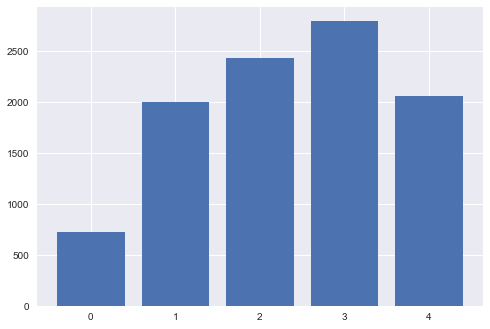

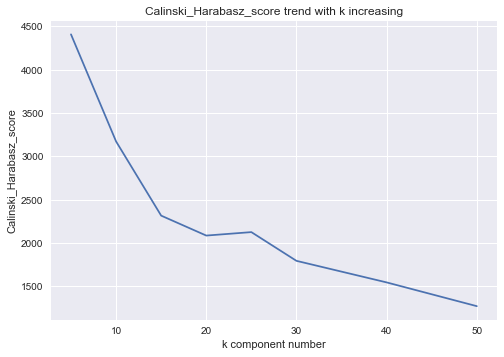

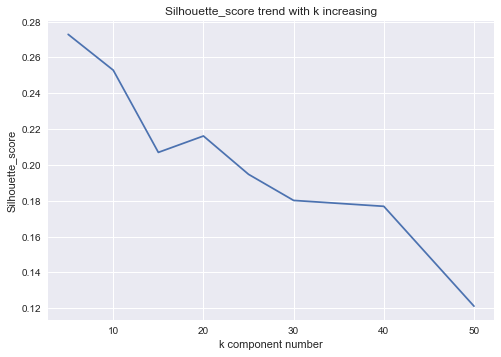

Calinski-Harabasz Score with n_clusters= 5 score: 3515.953795463789
Silhouette Score with n_clusters= 5 score: 0.25972324714213385
Calinski-Harabasz Score with n_clusters= 10 score: 2331.5498961696294
Silhouette Score with n_clusters= 10 score: 0.24435578918992723
Calinski-Harabasz Score with n_clusters= 15 score: 1684.7716078421427
Silhouette Score with n_clusters= 15 score: 0.18972531502251053
Calinski-Harabasz Score with n_clusters= 20 score: 1503.7236986910702
Silhouette Score with n_clusters= 20 score: 0.19358922850137536
Calinski-Harabasz Score with n_clusters= 25 score: 1244.817092496456
Silhouette Score with n_clusters= 25 score: 0.17963829443101523
Calinski-Harabasz Score with n_clusters= 30 score: 1156.3180161488422
Silhouette Score with n_clusters= 30 score: 0.17427038032455502
Calinski-Harabasz Score with n_clusters= 40 score: 892.2517758982401
Silhouette Score with n_clusters= 40 score: 0.17664366045639845
Calinski-Harabasz Score with n_clusters= 50 score: 764.067564678360

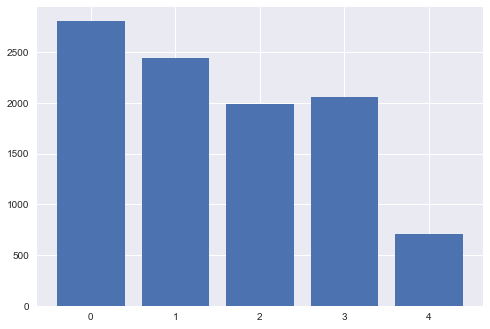

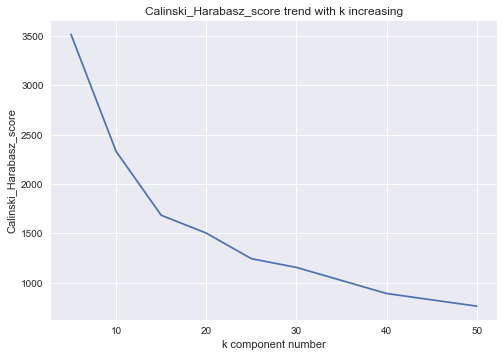

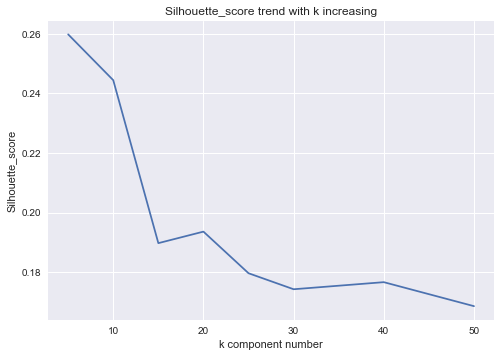

In [51]:
k_list = [5, 10, 15, 20, 25, 30, 40, 50]

select_k_and_display(k_list, X_minMax)

select_k_and_display(k_list, svd_X_minMax)

In [55]:
# poly kernel
poly_clustering = SpectralClustering(n_clusters=10, 
                                    n_init=10, 
                                    gamma=1.0,
                                    affinity='poly',
                                    assign_labels ='kmeans',
                                    degree=3,
                                    coef0=1,
                                    n_jobs=5)
# seller_clusters = clustering.labels_
# seller_affinity_matrix = clustering.affinity_matrix_

In [56]:
# knn kernel
knn_clustering = SpectralClustering(n_clusters=10, 
                                    n_init=10, 
                                    affinity='nearest_neighbors',
                                    n_neighbors=10,
                                    assign_labels ='kmeans',
                                    n_jobs=5)
# seller_clusters = clustering.labels_
# seller_affinity_matrix = clustering.affinity_matrix_

In [57]:
# cosine kernel
cos_clustering = SpectralClustering(n_clusters=10, 
                                n_init=10, 
                                affinity='cosine',
                                assign_labels ='kmeans',
                                n_jobs=5)
# seller_clusters = clustering.labels_
# seller_affinity_matrix = clustering.affinity_matrix_

In [67]:
model_list = [poly_clustering, knn_clustering, cos_clustering]

In [69]:

def select_k_and_kernel(k_list, data, model_list):
    for j in model_list:
        Calinski_Harabasz_k = 0
        Calinski_Harabasz_score = -1
        Calinski_Harabasz_cls = None
        ch_score_series = []

        Silhouette_k = 0
        Silhouette_score = -1
        Silhouette_cls = None
        sc_score_series = []
    
        for i in k_list:
            j.set_params(n_clusters=i)
            print("Begin tuning the model", j.get_params())
            cls = j.fit(data)
            y_pred = j.fit_predict(data)
            ch_score = metrics.calinski_harabaz_score(data, y_pred)
            s_score = metrics.silhouette_score(data, cls.labels_, metric='euclidean')

            ch_score_series.append(ch_score)
            sc_score_series.append(s_score)

            print("Calinski-Harabasz Score with n_clusters=", i,"score:", ch_score)
            print("Silhouette Score with n_clusters=", i,"score:", s_score)

            if ch_score > Calinski_Harabasz_score:
                Calinski_Harabasz_score = ch_score
                Calinski_Harabasz_k = i
                Calinski_Harabasz_cls = deepcopy(cls)

            if abs(s_score - 1) < abs(Silhouette_score - 1):
                Silhouette_score = s_score
                Silhouette_k = i
                Silhouette_cls = deepcopy(cls)

        print("The best Silhouette Score is "+str(Silhouette_score)+" and the best k is "+str(Silhouette_k))
        print("The best Calinski-Harabasz Score is "+str(Calinski_Harabasz_score)+" and the best k is "+str(Calinski_Harabasz_k))

        if Silhouette_k == Calinski_Harabasz_k:
            fit_data = data[np.argsort(Calinski_Harabasz_cls.labels_)]
    #         heat_map_for_original(fit_data)
            show_clusters(data, Calinski_Harabasz_cls)

        else:
            ch_fit_data = data[np.argsort(Calinski_Harabasz_cls.labels_)]
    #         heat_map_for_original(ch_fit_data)
            show_clusters(ch_fit_data, Calinski_Harabasz_cls)

            sc_fit_data = data[np.argsort(Silhouette_cls.labels_)]
    #         heat_map_for_original(sc_fit_data)
            show_clusters(sc_fit_data, Silhouette_cls)

        plt.plot(k_list, ch_score_series)
        plt.title('Calinski_Harabasz_score trend with k increasing')
        plt.xlabel('k component number')
        plt.ylabel('Calinski_Harabasz_score')
    #     plt.legend()
        plt.show()

        plt.plot(k_list, sc_score_series)
        plt.title('Silhouette_score trend with k increasing')
        plt.xlabel('k component number')
        plt.ylabel('Silhouette_score')
    #     plt.legend()
        plt.show()

Begin tuning the model {'affinity': 'poly', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 5, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 5 score: 3656.3081515197036
Silhouette Score with n_clusters= 5 score: 0.3256778595032854
Begin tuning the model {'affinity': 'poly', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 10, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 10 score: 2788.0009261922255
Silhouette Score with n_clusters= 10 score: 0.22053870392538316
Begin tuning the model {'affinity': 'poly', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 15, 'n_init': 10, 'n_jobs': 5, 

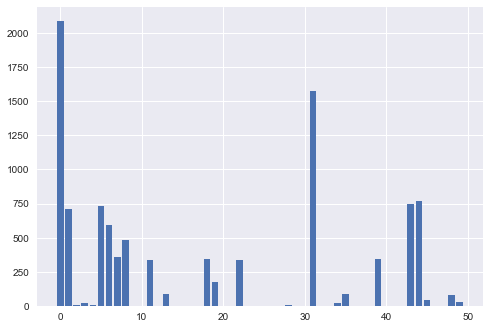

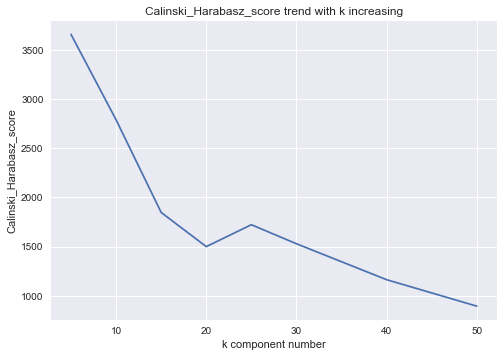

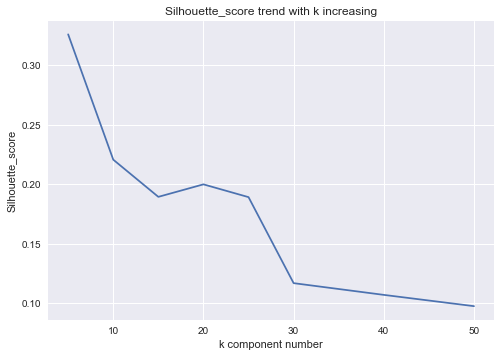

Begin tuning the model {'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 5, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 5 score: 4799.649401599832
Silhouette Score with n_clusters= 5 score: 0.23733602676127247
Begin tuning the model {'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 10, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 10 score: 3269.1007119786427
Silhouette Score with n_clusters= 10 score: 0.20111402900265438
Begin tuning the model {'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clu

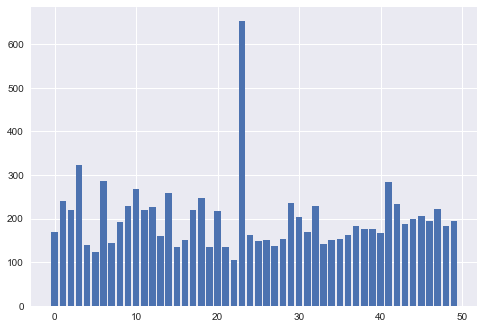

ValueError: x and y must have same first dimension, but have shapes (8,) and (16,)

In [62]:
k_list = [5, 10, 15, 20, 25, 30, 40, 50]
select_k_and_kernel(k_list, X_minMax, model_list)
select_k_and_kernel(k_list, svd_X_minMax, model_list)

Begin tuning the model {'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 5, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 5 score: 4805.401696307575
Silhouette Score with n_clusters= 5 score: 0.23765177159016398
Begin tuning the model {'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 10, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 10 score: 3274.4832286342753
Silhouette Score with n_clusters= 10 score: 0.20120755937992493
Begin tuning the model {'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clu

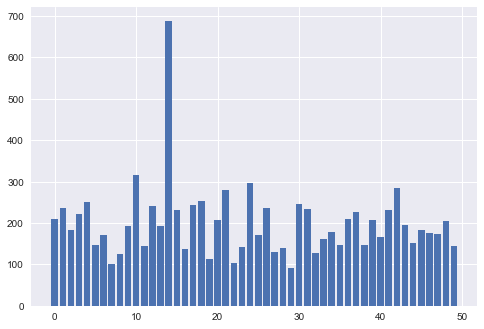

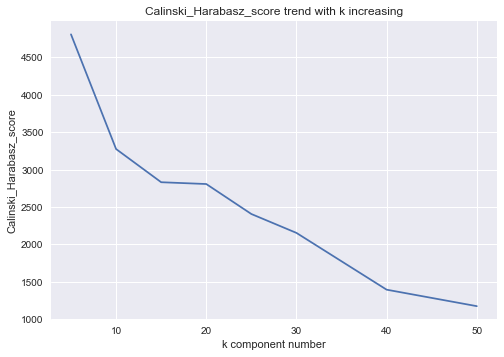

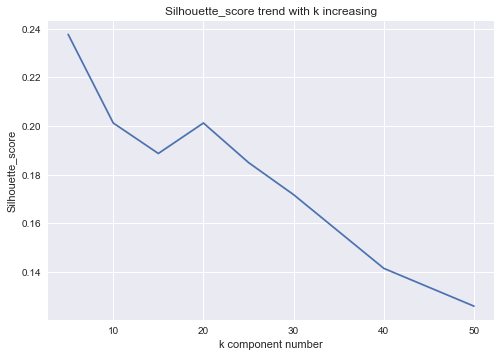

Begin tuning the model {'affinity': 'cosine', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 5, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 5 score: 1950.896316919533
Silhouette Score with n_clusters= 5 score: 0.2726052524960533
Begin tuning the model {'affinity': 'cosine', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 10, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 10 score: 897.4099037119352
Silhouette Score with n_clusters= 10 score: 0.2100776569328802
Begin tuning the model {'affinity': 'cosine', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 15, 'n_init': 10, 'n_jobs': 

KeyboardInterrupt: 

In [66]:
k_list = [5, 10, 15, 20, 25, 30, 40, 50]
select_k_and_kernel(k_list, X_minMax, model_list)
# select_k_and_kernel(k_list, svd_X_minMax, model_list)

Begin tuning the model {'affinity': 'poly', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 5, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 5 score: 2986.682388883157
Silhouette Score with n_clusters= 5 score: 0.31234189903917137
Begin tuning the model {'affinity': 'poly', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 10, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 10 score: 2213.139696917985
Silhouette Score with n_clusters= 10 score: 0.23358855642937232
Begin tuning the model {'affinity': 'poly', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 15, 'n_init': 10, 'n_jobs': 5, '

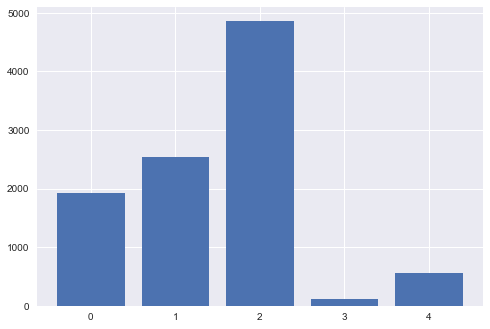

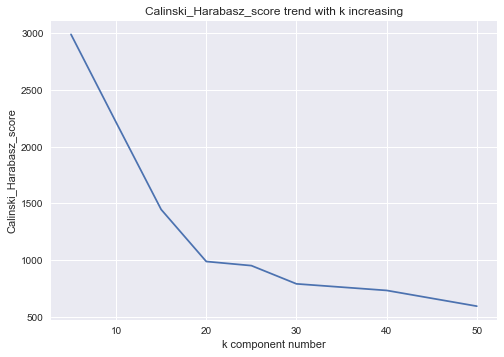

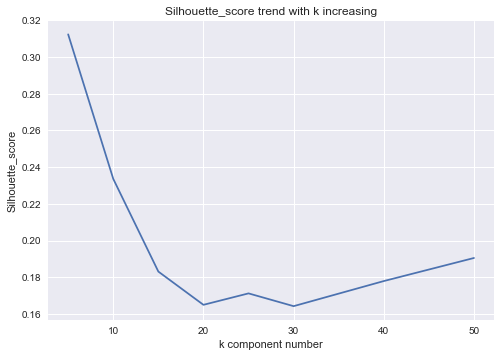

Begin tuning the model {'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 5, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 5 score: 3768.5895598901543
Silhouette Score with n_clusters= 5 score: 0.2199025657368196
Begin tuning the model {'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 10, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 10 score: 2405.7831668598983
Silhouette Score with n_clusters= 10 score: 0.18377694199335784
Begin tuning the model {'affinity': 'nearest_neighbors', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clu

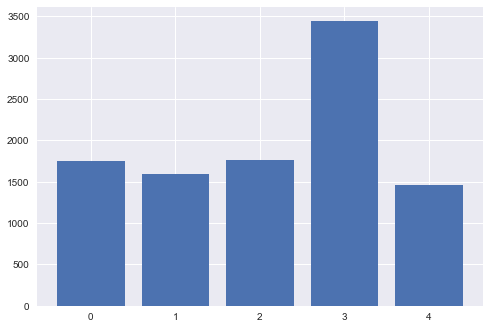

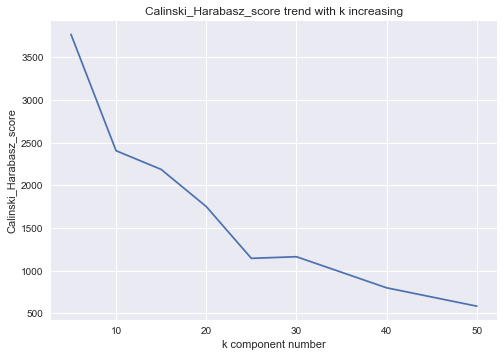

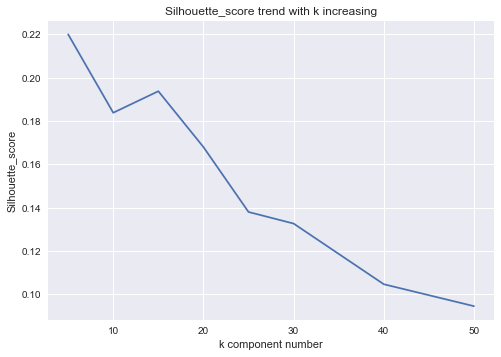

Begin tuning the model {'affinity': 'cosine', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 5, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 5 score: 1667.811125210815
Silhouette Score with n_clusters= 5 score: 0.2586547011691195
Begin tuning the model {'affinity': 'cosine', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 10, 'n_init': 10, 'n_jobs': 5, 'n_neighbors': 10, 'random_state': None}
Calinski-Harabasz Score with n_clusters= 10 score: 757.2352581806127
Silhouette Score with n_clusters= 10 score: 0.20589422605734758
Begin tuning the model {'affinity': 'cosine', 'assign_labels': 'kmeans', 'coef0': 1, 'degree': 3, 'eigen_solver': None, 'eigen_tol': 0.0, 'gamma': 1.0, 'kernel_params': None, 'n_clusters': 15, 'n_init': 10, 'n_jobs':

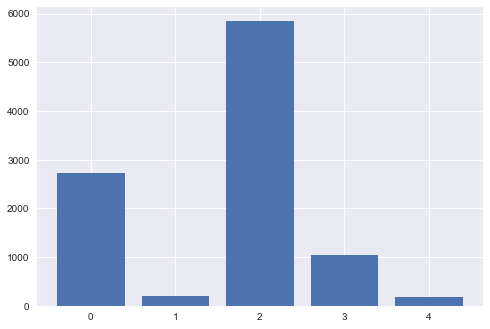

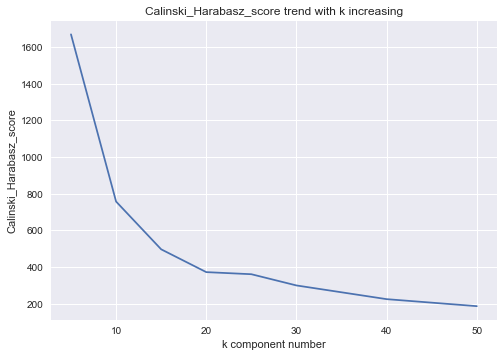

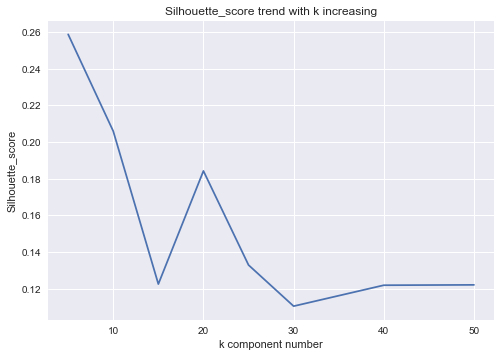

In [70]:
k_list = [5, 10, 15, 20, 25, 30, 40, 50]
# select_k_and_kernel(k_list, X_minMax, model_list)
select_k_and_kernel(k_list, svd_X_minMax, model_list)

In [72]:
col_names = ['records_number', 'buy_count', 'click_count',
       'successful_trade_ratio', 'item_number', 'category_number',
       'average_purchase_interval', 'last_purchase_date', 'openning_date',
       'maximum_click_per_day', 'maximum_purchase_per_day']
for i in range(100):
    col_names.append('svd_feature_'+str(i+1))
print(col_names)

['records_number', 'buy_count', 'click_count', 'successful_trade_ratio', 'item_number', 'category_number', 'average_purchase_interval', 'last_purchase_date', 'openning_date', 'maximum_click_per_day', 'maximum_purchase_per_day', 'svd_feature_1', 'svd_feature_2', 'svd_feature_3', 'svd_feature_4', 'svd_feature_5', 'svd_feature_6', 'svd_feature_7', 'svd_feature_8', 'svd_feature_9', 'svd_feature_10', 'svd_feature_11', 'svd_feature_12', 'svd_feature_13', 'svd_feature_14', 'svd_feature_15', 'svd_feature_16', 'svd_feature_17', 'svd_feature_18', 'svd_feature_19', 'svd_feature_20', 'svd_feature_21', 'svd_feature_22', 'svd_feature_23', 'svd_feature_24', 'svd_feature_25', 'svd_feature_26', 'svd_feature_27', 'svd_feature_28', 'svd_feature_29', 'svd_feature_30', 'svd_feature_31', 'svd_feature_32', 'svd_feature_33', 'svd_feature_34', 'svd_feature_35', 'svd_feature_36', 'svd_feature_37', 'svd_feature_38', 'svd_feature_39', 'svd_feature_40', 'svd_feature_41', 'svd_feature_42', 'svd_feature_43', 'svd_fe

In [73]:
new_df = pd.DataFrame(svd_X_minMax, columns = col_names)

In [81]:
new_df[:10]

,records_number,buy_count,click_count,successful_trade_ratio,item_number,category_number,average_purchase_interval,last_purchase_date,openning_date,maximum_click_per_day,...,svd_feature_94,svd_feature_95,svd_feature_96,svd_feature_97,svd_feature_98,svd_feature_99,svd_feature_100,seller_id,new_id,cluster_label
0,0.208521,1.000000,0.115710,1.000000,0.093617,0.008064,0.441860,0.000000,0.0,0.914241,...,2.360250e-06,0.000918,0.000000,0.000000,0.000108,0.000189,3.882551e-06,2086,1,4
1,0.491249,0.819619,0.109069,0.806918,0.107665,0.113759,0.418605,0.000003,0.0,0.102380,...,2.156220e-06,0.000520,0.000006,0.000057,0.000531,0.000377,2.209577e-06,4913,2,4
2,0.752175,0.809623,1.000000,0.000613,0.999314,0.000000,0.000000,0.000004,0.0,0.000274,...,0.000000e+00,0.000188,0.000011,0.000030,0.000000,0.000000,1.464933e-05,7522,3,3
3,0.052705,0.594423,0.325431,0.365330,0.442943,0.046519,0.046512,0.000011,0.0,0.064268,...,1.086209e-05,0.001208,0.000000,0.000000,0.000193,0.000000,0.000000e+00,528,4,2
4,0.561156,0.580505,0.009798,0.631719,0.013656,0.002450,0.046512,0.000011,0.0,0.515192,...,1.807724e-07,0.000460,0.000005,0.000000,0.000012,0.000030,1.856979e-07,5612,5,4
5,0.841684,0.451434,0.013582,0.485940,0.024342,0.347938,0.186047,0.000019,0.0,0.076842,...,7.808304e-06,0.003396,0.000000,0.000000,0.000446,0.000548,1.443103e-05,8417,6,4
6,0.291929,0.422253,0.016383,0.451245,0.031391,0.138665,0.046512,0.000021,0.0,0.145728,...,0.000000e+00,0.005981,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2920,7,4
7,0.535154,0.420488,0.016055,0.449590,0.030892,0.054404,0.139535,0.000022,0.0,0.156634,...,6.238773e-07,0.000105,0.000000,0.000000,0.000075,0.000001,2.061067e-06,5352,8,4
8,0.604460,0.348574,0.032687,0.355403,0.075868,0.132311,0.302326,0.000029,0.0,0.146483,...,0.000000e+00,0.003016,0.000000,0.000168,0.000255,0.001396,1.443992e-05,6045,9,4
9,0.052805,0.346159,0.032159,0.353211,0.075162,0.141497,0.116279,0.000030,0.0,0.118796,...,1.395755e-06,0.001209,0.000003,0.000245,0.000671,0.000362,1.664236e-05,529,10,2


In [75]:
new_df['seller_id'] = out_df['seller_id']
new_df['new_id'] = [i for i in range(1, 10001)]

In [77]:
clustering = SpectralClustering(n_clusters=5,
                                n_init=10, 
                                gamma=1.0,
                                affinity='rbf',
                                assign_labels ='kmeans',
                                n_jobs=5)
cls = clustering.fit(svd_X_minMax)
new_df['cluster_label'] = cls.labels_



In [79]:
print(metrics.silhouette_score(svd_X_minMax, cls.labels_, metric='euclidean'))

0.25972324714213385


In [83]:
new_df.to_csv("seller_clusters.csv", index=False)